In [1]:
import torch
import numpy as np
import os
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Hyperparameters etc. 
LEARNING_RATE = 2e-5
DEVICE = "cuda" if torch.cuda.is_available else "cpu"
WEIGHT_DECAY = 0
EPOCHS = 500



C:\Users\Uou\AppData\Local\Temp\ipykernel_43792\4128346770.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img, bboxes):
        for t in self.transforms:
            img, bboxes = t(img), bboxes

        return img, bboxes


transform = Compose([transforms.Resize((448, 448)), 
                     transforms.ToTensor(),])

class VOCDataset(Dataset):
    def __init__(self, csv_file, img_dir, label_dir, S=7, B=2, C=20, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.transform = transform
        self.S = S
        self.B = B
        self.C = C
        print(len(self.annotations))

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        label_path = os.path.join(self.label_dir, self.annotations.iloc[index, 1])
        boxes = []
        with open(label_path) as f:
            for label in f.readlines():
                class_label, x, y, width, height = [
                    float(x) if float(x) != int(float(x)) else int(x)
                    for x in label.replace("\n", "").split()
                ]

                boxes.append([class_label, x, y, width, height])

        img_path = os.path.join(self.img_dir, self.annotations.iloc[index, 0])
        image = Image.open(img_path)
        boxes = torch.tensor(boxes)
        

        if self.transform:
            image, boxes = self.transform(image, boxes)

        label_matrix = torch.zeros((self.S, self.S, self.C + 5 * self.B))
        for box in boxes:
            class_label, x, y, width, height = box.tolist()
            class_label = int(class_label)

            i = int(self.S * x)
            j = int(self.S * y)

            x_cell = self.S * x - i
            y_cell = self.S * y - j

            if label_matrix[i, j, 20] == 0:

                box_coordinates = torch.tensor(
                    [x_cell, y_cell, width, height]
                )
                
                label_matrix[i, j, 20] = 1
                label_matrix[i, j, 21:25] = box_coordinates
                label_matrix[i, j, class_label] = 1

        return image, label_matrix

In [3]:
BATCH_SIZE = 32 

ANNOT_DIR = "dataset/yolov1/30examples.csv"
IMG_DIR   = "dataset/yolov1/images"
LABEL_DIR = "dataset/yolov1/labels"

train_dataset = VOCDataset(
    csv_file=ANNOT_DIR,
    img_dir=IMG_DIR,
    label_dir=LABEL_DIR,
    transform=transform,
)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
)

30


In [4]:
img, box = next(iter(train_loader))

In [5]:
def imgshow(img, box):
    inx = torch.where(box[...,20].view(-1)==1)[0]
    index = []
    for i in inx:
        index.append(divmod(i.numpy(), 7))
    
    fig, ax = plt.subplots(figsize=(5,5))
    ax.imshow(img.permute(1,2,0))
    
    
    for _, (i, j) in enumerate(index):
        dx, dy, dw, dh = box[i, j, 21:25]

        x = dx*64 + i*64
        y = dy*64 + j*64
        w = int(dw*448)
        h = int(dh*448)
               
        xx = np.max((int(x-w/2), 0))
        yy = np.max((int(y-h/2), 0))
        
        ax.add_patch(
            patches.Circle(
            (x,y),
            edgecolor = 'red',
            fill = False
        ))
        
        ax.add_patch(
            patches.Rectangle(
            (xx,yy),
            w,h,
            edgecolor = 'red',
            fill = False
        ))



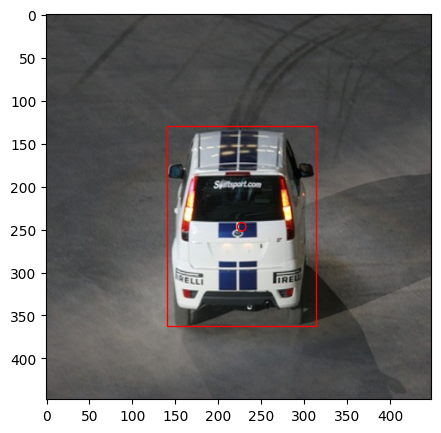

In [6]:
imgshow(img[11], box[11])


In [7]:
import torch
import torch.nn as nn

architecture_config = [
    # kernel_size, filters, stride, padding
    (7, 64, 2, 3),
    # M is simply maxpooling with stride=2 and kernel=2
    "M",
    (3, 192, 1, 1),
    "M",
    (1, 128, 1, 0),
    (3, 256, 1, 1),
    (1, 256, 1, 0),
    (3, 512, 1, 1),
    "M",
    [(1, 256, 1, 0), (3, 512, 1, 1), 4],
    (1, 512, 1, 0),
    (3, 1024, 1, 1),
    "M",
    [(1, 512, 1, 0), (3, 1024, 1, 1), 2],
    (3, 1024, 1, 1),
    (3, 1024, 2, 1),
    (3, 1024, 1, 1),
    (3, 1024, 1, 1),
]

class CBABlock(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super(CBABlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias=False, **kwargs)
        self.batchnorm = nn.BatchNorm2d(out_channels)
        self.leakyrelu = nn.LeakyReLU(0.1)

    def forward(self, x):
        return self.leakyrelu(self.batchnorm(self.conv(x)))
    
    
    
class Yolov1(nn.Module):
    def __init__(self, in_channels=3, **kwargs):
        super(Yolov1, self).__init__()
        self.architecture = architecture_config
        self.in_channels = in_channels
        self.darknet = self._create_conv_layers(self.architecture)
        self.fcs = self._create_fcs(**kwargs)

    def forward(self, x):
        x = self.darknet(x)
        return self.fcs(torch.flatten(x, start_dim=1))

    def _create_conv_layers(self, architecture):
        layers = []
        in_channels = self.in_channels

        for x in architecture:
            if type(x) == tuple:
                layers += [
                    CBABlock(
                        in_channels, x[1], kernel_size=x[0], stride=x[2], padding=x[3],
                    )
                ]
                in_channels = x[1]

            elif type(x) == str:
                layers += [nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))]

            elif type(x) == list:
                conv1 = x[0]
                conv2 = x[1]
                num_repeats = x[2]

                for _ in range(num_repeats):
                    layers += [
                        CBABlock(
                            in_channels,
                            conv1[1],
                            kernel_size=conv1[0],
                            stride=conv1[2],
                            padding=conv1[3],
                        )
                    ]
                    layers += [
                        CBABlock(
                            conv1[1],
                            conv2[1],
                            kernel_size=conv2[0],
                            stride=conv2[2],
                            padding=conv2[3],
                        )
                    ]
                    in_channels = conv2[1]

        return nn.Sequential(*layers)

    def _create_fcs(self, split_size, num_boxes, num_classes):
        S, B, C = split_size, num_boxes, num_classes

        # In original paper this should be
        # nn.Linear(1024*S*S, 4096),
        # nn.LeakyReLU(0.1),
        # nn.Linear(4096, S*S*(B*5+C))

        return nn.Sequential(
            nn.Flatten(),
            nn.Linear(1024 * S * S, 496),
            nn.Dropout(0.0),
            nn.LeakyReLU(0.1),
            nn.Linear(496, S * S * (C + B * 5)),
        )

In [8]:
def intersection_over_union(boxes_preds, boxes_labels, box_format="midpoint"):

    if box_format == "midpoint":
        box1_x1 = boxes_preds[..., 0:1] - boxes_preds[..., 2:3] / 2 # x - w/2
        box1_y1 = boxes_preds[..., 1:2] - boxes_preds[..., 3:4] / 2 # y - h/w
        box1_x2 = boxes_preds[..., 0:1] + boxes_preds[..., 2:3] / 2 # x + w/2
        box1_y2 = boxes_preds[..., 1:2] + boxes_preds[..., 3:4] / 2 # y + h/2
        
        box2_x1 = boxes_labels[..., 0:1] - boxes_labels[..., 2:3] / 2
        box2_y1 = boxes_labels[..., 1:2] - boxes_labels[..., 3:4] / 2
        box2_x2 = boxes_labels[..., 0:1] + boxes_labels[..., 2:3] / 2
        box2_y2 = boxes_labels[..., 1:2] + boxes_labels[..., 3:4] / 2

    if box_format == "corners":
        box1_x1 = boxes_preds[..., 0:1]
        box1_y1 = boxes_preds[..., 1:2]
        box1_x2 = boxes_preds[..., 2:3]
        box1_y2 = boxes_preds[..., 3:4]  # (N, 1)
        
        box2_x1 = boxes_labels[..., 0:1]
        box2_y1 = boxes_labels[..., 1:2]
        box2_x2 = boxes_labels[..., 2:3]
        box2_y2 = boxes_labels[..., 3:4]

    x1 = torch.max(box1_x1, box2_x1)
    y1 = torch.max(box1_y1, box2_y1)
    x2 = torch.min(box1_x2, box2_x2)
    y2 = torch.min(box1_y2, box2_y2)

    # .clamp(0) is for the case when they do not intersect
    intersection = (x2 - x1).clamp(0) * (y2 - y1).clamp(0)

    box1_area = abs((box1_x2 - box1_x1) * (box1_y2 - box1_y1))
    box2_area = abs((box2_x2 - box2_x1) * (box2_y2 - box2_y1))

    return intersection / (box1_area + box2_area - intersection + 1e-6)


In [9]:
class YoloLoss(nn.Module):
    def __init__(self, S=7, B=2, C=20):
        super(YoloLoss, self).__init__()
        self.mse = nn.MSELoss(reduction="sum")

        self.S = S
        self.B = B
        self.C = C

        self.lambda_noobj = 0.5
        self.lambda_coord = 5

    def forward(self, predictions, target):
        # predictions are shaped (BATCH_SIZE, S*S*(C+B*5) when inputted
        predictions = predictions.reshape(-1, self.S, self.S, self.C + self.B * 5)

        # Calculate IoU for the two predicted bounding boxes with target bbox
        iou_b1 = intersection_over_union(predictions[..., 21:25], target[..., 21:25])
        iou_b2 = intersection_over_union(predictions[..., 26:30], target[..., 21:25])
        ious = torch.cat([iou_b1.unsqueeze(0), iou_b2.unsqueeze(0)], dim=0)

        # Take the box with highest IoU out of the two prediction
        # Note that bestbox will be indices of 0, 1 for which bbox was best
        iou_maxes, bestbox = torch.max(ious, dim=0)
        exists_box = target[..., 20].unsqueeze(3)  # in paper this is Iobj_i

        # ======================== #
        #   FOR BOX COORDINATES    #
        # ======================== #

        # Set boxes with no object in them to 0. We only take out one of the two 
        # predictions, which is the one with highest Iou calculated previously.
        box_predictions = exists_box * (
            (
                bestbox * predictions[..., 26:30]
                + (1 - bestbox) * predictions[..., 21:25]
            )
        )

        box_targets = exists_box * target[..., 21:25] # for label

        # Take sqrt of width, height of boxes to ensure that
        box_predictions[..., 2:4] = torch.sign(box_predictions[..., 2:4]) * torch.sqrt(
            torch.abs(box_predictions[..., 2:4] + 1e-6)
        )
        box_targets[..., 2:4] = torch.sqrt(box_targets[..., 2:4]) # for label

        box_loss = self.mse(
            torch.flatten(box_predictions, end_dim=-2),
            torch.flatten(box_targets, end_dim=-2),
        )

        # ==================== #
        #   FOR OBJECT LOSS    #
        # ==================== #

        # pred_box is the confidence score for the bbox with highest IoU
        pred_box = (
            bestbox * predictions[..., 25:26] + (1 - bestbox) * predictions[..., 20:21]
        )

        object_loss = self.mse(
            torch.flatten(exists_box * pred_box),                 # exist box: 0 or 1
            torch.flatten(exists_box * target[..., 20:21]),
        )

        # ======================= #
        #   FOR NO OBJECT LOSS    #
        # ======================= #

        no_object_loss = self.mse(
            torch.flatten((1 - exists_box) * predictions[..., 20:21], start_dim=1),
            torch.flatten((1 - exists_box) * target[..., 20:21], start_dim=1),
        )

        no_object_loss += self.mse(
            torch.flatten((1 - exists_box) * predictions[..., 25:26], start_dim=1),
            torch.flatten((1 - exists_box) * target[..., 20:21], start_dim=1)
        )

        # ================== #
        #   FOR CLASS LOSS   #
        # ================== #

        class_loss = self.mse(
            torch.flatten(exists_box * predictions[..., :20], end_dim=-2,),
            torch.flatten(exists_box * target[..., :20], end_dim=-2,),
        )

        loss = (
            self.lambda_coord * box_loss  # first two rows in paper
            + object_loss  # third row in paper
            + self.lambda_noobj * no_object_loss  # forth row
            + class_loss  # fifth row
        )

        return loss

In [10]:
import torch.optim as optim


model = Yolov1(split_size=7, num_boxes=2, num_classes=20).to(DEVICE)
optimizer = optim.Adam(
    model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY
)
loss_fn = YoloLoss()


In [11]:
from tqdm import tqdm
model.train()

for epoch in range(EPOCHS):

    mean_loss = []

    for batch_idx, (x, y) in enumerate(tqdm(train_loader)):
        x, y = x.to(DEVICE), y.to(DEVICE)
        out = model(x)
        loss = loss_fn(out, y)
        mean_loss.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Mean loss was {sum(mean_loss)/len(mean_loss)}")

100%|██████████| 1/1 [00:00<00:00,  1.94it/s]


Mean loss was 897.4225463867188


100%|██████████| 1/1 [00:00<00:00,  8.00it/s]


Mean loss was 474.9403076171875


100%|██████████| 1/1 [00:00<00:00,  7.88it/s]


Mean loss was 292.7176513671875


100%|██████████| 1/1 [00:00<00:00,  7.82it/s]


Mean loss was 203.7224884033203


100%|██████████| 1/1 [00:00<00:00,  7.87it/s]


Mean loss was 149.71768188476562


100%|██████████| 1/1 [00:00<00:00,  7.22it/s]


Mean loss was 126.03671264648438


100%|██████████| 1/1 [00:00<00:00,  8.35it/s]


Mean loss was 107.134521484375


100%|██████████| 1/1 [00:00<00:00,  8.15it/s]


Mean loss was 94.14171600341797


100%|██████████| 1/1 [00:00<00:00,  7.52it/s]


Mean loss was 81.55400848388672


100%|██████████| 1/1 [00:00<00:00,  7.64it/s]


Mean loss was 71.96070098876953


100%|██████████| 1/1 [00:00<00:00,  7.75it/s]


Mean loss was 65.8716049194336


100%|██████████| 1/1 [00:00<00:00,  8.03it/s]


Mean loss was 58.685813903808594


100%|██████████| 1/1 [00:00<00:00,  8.07it/s]


Mean loss was 53.48257064819336


100%|██████████| 1/1 [00:00<00:00,  7.81it/s]


Mean loss was 48.288726806640625


100%|██████████| 1/1 [00:00<00:00,  7.43it/s]


Mean loss was 45.886924743652344


100%|██████████| 1/1 [00:00<00:00,  8.07it/s]


Mean loss was 44.53065872192383


100%|██████████| 1/1 [00:00<00:00,  7.60it/s]


Mean loss was 42.41442108154297


100%|██████████| 1/1 [00:00<00:00,  8.06it/s]


Mean loss was 37.55449676513672


100%|██████████| 1/1 [00:00<00:00,  7.94it/s]


Mean loss was 35.73741912841797


100%|██████████| 1/1 [00:00<00:00,  8.07it/s]


Mean loss was 36.05237579345703


100%|██████████| 1/1 [00:00<00:00,  6.24it/s]


Mean loss was 33.710174560546875


100%|██████████| 1/1 [00:00<00:00,  8.27it/s]


Mean loss was 30.603710174560547


100%|██████████| 1/1 [00:00<00:00,  8.19it/s]


Mean loss was 26.758419036865234


100%|██████████| 1/1 [00:00<00:00,  7.91it/s]


Mean loss was 25.794466018676758


100%|██████████| 1/1 [00:00<00:00,  8.30it/s]


Mean loss was 24.513797760009766


100%|██████████| 1/1 [00:00<00:00,  7.76it/s]


Mean loss was 25.71967887878418


100%|██████████| 1/1 [00:00<00:00,  7.82it/s]


Mean loss was 24.55926513671875


100%|██████████| 1/1 [00:00<00:00,  8.13it/s]


Mean loss was 24.438425064086914


100%|██████████| 1/1 [00:00<00:00,  8.33it/s]


Mean loss was 24.423961639404297


100%|██████████| 1/1 [00:00<00:00,  7.40it/s]


Mean loss was 30.952627182006836


100%|██████████| 1/1 [00:00<00:00,  8.03it/s]


Mean loss was 28.890995025634766


100%|██████████| 1/1 [00:00<00:00,  8.01it/s]


Mean loss was 25.980335235595703


100%|██████████| 1/1 [00:00<00:00,  8.13it/s]


Mean loss was 22.898712158203125


100%|██████████| 1/1 [00:00<00:00,  8.12it/s]


Mean loss was 18.23929214477539


100%|██████████| 1/1 [00:00<00:00,  8.09it/s]


Mean loss was 17.465784072875977


100%|██████████| 1/1 [00:00<00:00,  8.07it/s]


Mean loss was 16.115015029907227


100%|██████████| 1/1 [00:00<00:00,  7.83it/s]


Mean loss was 16.860431671142578


100%|██████████| 1/1 [00:00<00:00,  7.56it/s]


Mean loss was 20.737167358398438


100%|██████████| 1/1 [00:00<00:00,  7.02it/s]


Mean loss was 22.806537628173828


100%|██████████| 1/1 [00:00<00:00,  8.02it/s]


Mean loss was 20.898395538330078


100%|██████████| 1/1 [00:00<00:00,  8.19it/s]


Mean loss was 16.285987854003906


100%|██████████| 1/1 [00:00<00:00,  8.17it/s]


Mean loss was 16.53092384338379


100%|██████████| 1/1 [00:00<00:00,  8.49it/s]


Mean loss was 13.85689640045166


100%|██████████| 1/1 [00:00<00:00,  7.73it/s]


Mean loss was 13.076545715332031


100%|██████████| 1/1 [00:00<00:00,  8.11it/s]


Mean loss was 13.311290740966797


100%|██████████| 1/1 [00:00<00:00,  8.47it/s]


Mean loss was 10.489826202392578


100%|██████████| 1/1 [00:00<00:00,  7.28it/s]


Mean loss was 11.126130104064941


100%|██████████| 1/1 [00:00<00:00,  8.29it/s]


Mean loss was 9.63569450378418


100%|██████████| 1/1 [00:00<00:00,  7.71it/s]


Mean loss was 9.071722030639648


100%|██████████| 1/1 [00:00<00:00,  7.72it/s]


Mean loss was 8.334348678588867


100%|██████████| 1/1 [00:00<00:00,  7.87it/s]


Mean loss was 8.154840469360352


100%|██████████| 1/1 [00:00<00:00,  7.50it/s]


Mean loss was 8.708215713500977


100%|██████████| 1/1 [00:00<00:00,  6.92it/s]


Mean loss was 8.141258239746094


100%|██████████| 1/1 [00:00<00:00,  8.25it/s]


Mean loss was 6.61524772644043


100%|██████████| 1/1 [00:00<00:00,  7.64it/s]


Mean loss was 6.652203559875488


100%|██████████| 1/1 [00:00<00:00,  8.06it/s]


Mean loss was 6.716610431671143


100%|██████████| 1/1 [00:00<00:00,  7.97it/s]


Mean loss was 5.8502960205078125


100%|██████████| 1/1 [00:00<00:00,  7.73it/s]


Mean loss was 5.144283294677734


100%|██████████| 1/1 [00:00<00:00,  6.87it/s]


Mean loss was 4.7680583000183105


100%|██████████| 1/1 [00:00<00:00,  8.43it/s]


Mean loss was 3.987083673477173


100%|██████████| 1/1 [00:00<00:00,  7.91it/s]


Mean loss was 3.7136447429656982


100%|██████████| 1/1 [00:00<00:00,  8.51it/s]


Mean loss was 4.035754680633545


100%|██████████| 1/1 [00:00<00:00,  8.47it/s]


Mean loss was 4.329102516174316


100%|██████████| 1/1 [00:00<00:00,  8.16it/s]


Mean loss was 5.532330513000488


100%|██████████| 1/1 [00:00<00:00,  7.07it/s]


Mean loss was 5.356000900268555


100%|██████████| 1/1 [00:00<00:00,  8.22it/s]


Mean loss was 4.031656265258789


100%|██████████| 1/1 [00:00<00:00,  7.71it/s]


Mean loss was 4.319211959838867


100%|██████████| 1/1 [00:00<00:00,  7.92it/s]


Mean loss was 3.789999485015869


100%|██████████| 1/1 [00:00<00:00,  8.02it/s]


Mean loss was 4.614847183227539


100%|██████████| 1/1 [00:00<00:00,  7.83it/s]


Mean loss was 4.186332702636719


100%|██████████| 1/1 [00:00<00:00,  6.82it/s]


Mean loss was 4.879949569702148


100%|██████████| 1/1 [00:00<00:00,  8.33it/s]


Mean loss was 5.1657185554504395


100%|██████████| 1/1 [00:00<00:00,  7.83it/s]


Mean loss was 6.738293647766113


100%|██████████| 1/1 [00:00<00:00,  7.59it/s]


Mean loss was 5.848490238189697


100%|██████████| 1/1 [00:00<00:00,  8.04it/s]


Mean loss was 3.952568769454956


100%|██████████| 1/1 [00:00<00:00,  7.74it/s]


Mean loss was 6.667152404785156


100%|██████████| 1/1 [00:00<00:00,  7.95it/s]


Mean loss was 10.178460121154785


100%|██████████| 1/1 [00:00<00:00,  7.40it/s]


Mean loss was 10.337509155273438


100%|██████████| 1/1 [00:00<00:00,  8.06it/s]


Mean loss was 13.014082908630371


100%|██████████| 1/1 [00:00<00:00,  8.50it/s]


Mean loss was 11.385421752929688


100%|██████████| 1/1 [00:00<00:00,  7.93it/s]


Mean loss was 9.146785736083984


100%|██████████| 1/1 [00:00<00:00,  7.67it/s]


Mean loss was 8.426027297973633


100%|██████████| 1/1 [00:00<00:00,  8.37it/s]


Mean loss was 7.843496322631836


100%|██████████| 1/1 [00:00<00:00,  7.91it/s]


Mean loss was 8.892110824584961


100%|██████████| 1/1 [00:00<00:00,  8.45it/s]


Mean loss was 9.268403053283691


100%|██████████| 1/1 [00:00<00:00,  7.54it/s]


Mean loss was 9.957073211669922


100%|██████████| 1/1 [00:00<00:00,  7.92it/s]


Mean loss was 9.841031074523926


100%|██████████| 1/1 [00:00<00:00,  7.99it/s]


Mean loss was 7.078278541564941


100%|██████████| 1/1 [00:00<00:00,  7.47it/s]


Mean loss was 17.664520263671875


100%|██████████| 1/1 [00:00<00:00,  7.88it/s]


Mean loss was 20.06172752380371


100%|██████████| 1/1 [00:00<00:00,  8.19it/s]


Mean loss was 21.54306411743164


100%|██████████| 1/1 [00:00<00:00,  7.02it/s]


Mean loss was 18.693632125854492


100%|██████████| 1/1 [00:00<00:00,  8.05it/s]


Mean loss was 15.17885684967041


100%|██████████| 1/1 [00:00<00:00,  7.99it/s]


Mean loss was 11.157652854919434


100%|██████████| 1/1 [00:00<00:00,  8.06it/s]


Mean loss was 9.925882339477539


100%|██████████| 1/1 [00:00<00:00,  8.30it/s]


Mean loss was 10.805415153503418


100%|██████████| 1/1 [00:00<00:00,  7.96it/s]


Mean loss was 11.39178466796875


100%|██████████| 1/1 [00:00<00:00,  8.12it/s]


Mean loss was 11.833828926086426


100%|██████████| 1/1 [00:00<00:00,  8.31it/s]


Mean loss was 11.949044227600098


100%|██████████| 1/1 [00:00<00:00,  7.99it/s]


Mean loss was 12.222896575927734


100%|██████████| 1/1 [00:00<00:00,  8.02it/s]


Mean loss was 9.004295349121094


100%|██████████| 1/1 [00:00<00:00,  7.97it/s]


Mean loss was 7.691636562347412


100%|██████████| 1/1 [00:00<00:00,  8.54it/s]


Mean loss was 6.476100921630859


100%|██████████| 1/1 [00:00<00:00,  7.59it/s]


Mean loss was 5.547894477844238


100%|██████████| 1/1 [00:00<00:00,  7.79it/s]


Mean loss was 5.3747477531433105


100%|██████████| 1/1 [00:00<00:00,  8.03it/s]


Mean loss was 10.512348175048828


100%|██████████| 1/1 [00:00<00:00,  7.84it/s]


Mean loss was 12.386089324951172


100%|██████████| 1/1 [00:00<00:00,  8.31it/s]


Mean loss was 13.248889923095703


100%|██████████| 1/1 [00:00<00:00,  7.98it/s]


Mean loss was 10.151535034179688


100%|██████████| 1/1 [00:00<00:00,  6.73it/s]


Mean loss was 9.16646671295166


100%|██████████| 1/1 [00:00<00:00,  8.26it/s]


Mean loss was 9.073424339294434


100%|██████████| 1/1 [00:00<00:00,  8.08it/s]


Mean loss was 8.399189949035645


100%|██████████| 1/1 [00:00<00:00,  8.23it/s]


Mean loss was 7.5973639488220215


100%|██████████| 1/1 [00:00<00:00,  8.42it/s]


Mean loss was 6.017388343811035


100%|██████████| 1/1 [00:00<00:00,  7.66it/s]


Mean loss was 5.484699249267578


100%|██████████| 1/1 [00:00<00:00,  7.82it/s]


Mean loss was 4.723545074462891


100%|██████████| 1/1 [00:00<00:00,  7.90it/s]


Mean loss was 3.949814558029175


100%|██████████| 1/1 [00:00<00:00,  7.86it/s]


Mean loss was 4.027811050415039


100%|██████████| 1/1 [00:00<00:00,  7.16it/s]


Mean loss was 3.4816837310791016


100%|██████████| 1/1 [00:00<00:00,  7.94it/s]


Mean loss was 2.9259731769561768


100%|██████████| 1/1 [00:00<00:00,  7.81it/s]


Mean loss was 2.6061766147613525


100%|██████████| 1/1 [00:00<00:00,  8.33it/s]


Mean loss was 2.572540521621704


100%|██████████| 1/1 [00:00<00:00,  8.06it/s]


Mean loss was 2.576396942138672


100%|██████████| 1/1 [00:00<00:00,  7.99it/s]


Mean loss was 2.042891025543213


100%|██████████| 1/1 [00:00<00:00,  8.02it/s]


Mean loss was 3.1518912315368652


100%|██████████| 1/1 [00:00<00:00,  7.58it/s]


Mean loss was 5.2777323722839355


100%|██████████| 1/1 [00:00<00:00,  7.83it/s]


Mean loss was 7.325765609741211


100%|██████████| 1/1 [00:00<00:00,  7.76it/s]


Mean loss was 7.78847599029541


100%|██████████| 1/1 [00:00<00:00,  7.39it/s]


Mean loss was 7.104471206665039


100%|██████████| 1/1 [00:00<00:00,  8.28it/s]


Mean loss was 4.2444634437561035


100%|██████████| 1/1 [00:00<00:00,  8.39it/s]


Mean loss was 4.628386497497559


100%|██████████| 1/1 [00:00<00:00,  8.03it/s]


Mean loss was 10.30040454864502


100%|██████████| 1/1 [00:00<00:00,  7.94it/s]


Mean loss was 12.256020545959473


100%|██████████| 1/1 [00:00<00:00,  8.16it/s]


Mean loss was 13.049893379211426


100%|██████████| 1/1 [00:00<00:00,  8.20it/s]


Mean loss was 13.409774780273438


100%|██████████| 1/1 [00:00<00:00,  8.15it/s]


Mean loss was 10.813720703125


100%|██████████| 1/1 [00:00<00:00,  7.86it/s]


Mean loss was 8.317975044250488


100%|██████████| 1/1 [00:00<00:00,  7.08it/s]


Mean loss was 6.509993553161621


100%|██████████| 1/1 [00:00<00:00,  7.87it/s]


Mean loss was 5.257444381713867


100%|██████████| 1/1 [00:00<00:00,  7.72it/s]


Mean loss was 4.358162879943848


100%|██████████| 1/1 [00:00<00:00,  8.19it/s]


Mean loss was 4.7257232666015625


100%|██████████| 1/1 [00:00<00:00,  8.10it/s]


Mean loss was 4.378137588500977


100%|██████████| 1/1 [00:00<00:00,  7.94it/s]


Mean loss was 5.059197902679443


100%|██████████| 1/1 [00:00<00:00,  7.85it/s]


Mean loss was 5.439714431762695


100%|██████████| 1/1 [00:00<00:00,  7.97it/s]


Mean loss was 4.073810577392578


100%|██████████| 1/1 [00:00<00:00,  8.05it/s]


Mean loss was 3.2001900672912598


100%|██████████| 1/1 [00:00<00:00,  8.16it/s]


Mean loss was 3.744442939758301


100%|██████████| 1/1 [00:00<00:00,  7.66it/s]


Mean loss was 4.4919023513793945


100%|██████████| 1/1 [00:00<00:00,  8.08it/s]


Mean loss was 9.377328872680664


100%|██████████| 1/1 [00:00<00:00,  7.97it/s]


Mean loss was 10.157928466796875


100%|██████████| 1/1 [00:00<00:00,  7.78it/s]


Mean loss was 9.699821472167969


100%|██████████| 1/1 [00:00<00:00,  8.03it/s]


Mean loss was 7.575911045074463


100%|██████████| 1/1 [00:00<00:00,  8.03it/s]


Mean loss was 5.006954193115234


100%|██████████| 1/1 [00:00<00:00,  8.10it/s]


Mean loss was 3.8703179359436035


100%|██████████| 1/1 [00:00<00:00,  7.87it/s]


Mean loss was 3.7645115852355957


100%|██████████| 1/1 [00:00<00:00,  8.23it/s]


Mean loss was 3.80385422706604


100%|██████████| 1/1 [00:00<00:00,  7.89it/s]


Mean loss was 9.375587463378906


  0%|          | 0/1 [00:00<?, ?it/s]


KeyboardInterrupt: 

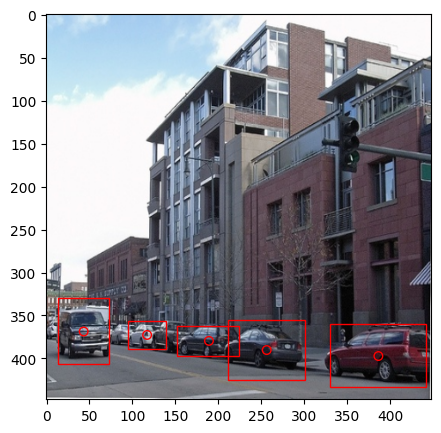

In [12]:
model.eval()
model.to(DEVICE)
pred = model(x)
pred = pred.view(-1, 7, 7, 30)

inx = 3
pred[inx,...,20] = (pred[inx,...,20]>0.60)*1
imgshow(x[inx].detach().cpu(),pred[inx].detach().cpu())

In [14]:
pred = model(x)
pred = pred.view(-1, 7, 7, 30).detach().cpu()
pred[1,...,20]

tensor([[ 1.8325e-03, -6.6024e-04,  7.9799e-05,  1.4450e-04, -1.8972e-04,
         -1.4578e-04,  1.2489e-03],
        [ 2.1046e-03,  3.6411e-04,  5.7860e-04, -2.1800e-03,  1.8109e-03,
          2.8773e-04,  1.7909e-03],
        [ 7.5695e-04, -6.4284e-04, -6.7582e-04,  2.3062e-03,  1.8463e-05,
          1.6550e-03, -1.7426e-03],
        [-2.6220e-03,  1.9465e-04, -2.0301e-04,  9.9750e-01, -1.6554e-03,
         -7.6268e-04, -4.4264e-03],
        [-5.9467e-04, -2.3973e-03, -9.2316e-04, -2.3937e-03,  4.4068e-04,
         -4.6625e-04,  1.5016e-03],
        [-3.7565e-04,  2.6586e-05,  5.9574e-04, -1.6640e-03,  2.3937e-04,
          2.0802e-03,  2.3747e-03],
        [-8.0988e-05,  6.9503e-04,  3.9253e-04, -1.1004e-04, -6.9465e-04,
          7.9364e-05, -1.1226e-03]])

In [15]:
torch.save(model.state_dict(), 'yolo1.pth')